# Dependencias

In [1]:
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt

# Load Data

In [2]:
data = pd.read_csv('./mails_cleaned_v2.csv')
print(data.shape)

(11091, 11)


In [3]:
# tmp
data = data.head(n=1500)

In [4]:
data=data.drop(columns=['Unnamed: 0','X-cc','X-bcc'])
data=data.dropna(axis=0,subset=['body'],how='any')
print(data.shape)
data.head()

(1500, 8)


,file,Message-ID,Date,From,To,Subject,body,body_clean
0,allen-p/_sent_mail/105.,<13116875.1075855687561.JavaMail.evans@thyme>,2000-10-09 14:16:00,{'phillip.allen@enron.com'},{'keith.holst@enron.com'},Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,from our initial set of meetings with the trad...
1,allen-p/_sent_mail/106.,<2707340.1075855687584.JavaMail.evans@thyme>,2000-10-09 14:00:00,{'phillip.allen@enron.com'},{'keith.holst@enron.com'},Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,from our initial set of meetings with the trad...
2,allen-p/_sent_mail/140.,<2751799.1075855688335.JavaMail.evans@thyme>,2000-09-11 16:57:00,{'phillip.allen@enron.com'},{'keith.holst@enron.com'},Westgate Proforma-Phillip Allen.xls,---------------------- Forwarded by Phillip K ...,enclosed is the preliminary proforma for the w...
3,allen-p/_sent_mail/18.,<22040365.1075855378763.JavaMail.evans@thyme>,2001-04-30 21:22:00,{'phillip.allen@enron.com'},{'keith.holst@enron.com'},Request from Steve Kean,\n---------------------- Forwarded by Phillip ...,alan steve has asked that you update the power...
4,allen-p/_sent_mail/19.,<25043030.1075855378785.JavaMail.evans@thyme>,2001-04-30 20:37:00,{'phillip.allen@enron.com'},{'keith.holst@enron.com'},Request from Steve Kean,\n---------------------- Forwarded by Phillip ...,alan steve has asked that you update the power...


# Pre-Procesamiento

In [5]:
import re
def clean_from_mails(message):
  mail_addresses = re.findall(r'\(?[A-Za-z0-9_\-\.]+@[A-Za-zb0-9_\-\.]+\.com\)?',message)
  if mail_addresses != []:
    for mail_address in mail_addresses:
      message=message.replace(mail_address,'').strip()
  return message

In [6]:
# Eliminar emails del body
data['body_clean']=data['body'].map(clean_from_mails)

In [7]:
# Eliminar palabras con digitos y signos de puntuacion
data['body_clean']=data['body_clean'].map(lambda x: ' '.join(re.sub(r'[^a-zA-Z]',' ',x).split()))

In [8]:
# Pasar todo a minusculas
data['body_clean']=data['body_clean'].map(lambda x: x.lower())

## Stopwords

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/kref/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
my_stopwords = stopwords.words('english')
# Excluir palabras de una sola letra
for i in range(ord('a'),ord('z')+1):
  my_stopwords.append(chr(i))
# Añadir would
my_stopwords = my_stopwords + ['also','please','would']
print(f'Stopwords final ({len(my_stopwords)}):')
print(my_stopwords)

Stopwords final (208):
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 

In [11]:
def clean_msg_stopwords(message_body):
    words = message_body.split()
    words = [w for w in words if w not in set(my_stopwords)]
    return ' '.join(words)

In [12]:
# Eliminar stopwords
data['body_clean']=data.body_clean.apply(clean_msg_stopwords)

In [13]:
data=data.dropna(axis=0,subset=['body_clean'],how='any')
print(data.shape)

(1500, 8)


## Tokenizacion

In [14]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kref/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
word_vector = []
for doc in data['body_clean']:
  word_vector.append(doc.split())
my_vocabulary = [item for sublist in word_vector for item in sublist]

In [16]:
print(f'El vocabulario consta de {len(my_vocabulary)} elementos y {len(set(my_vocabulary))} palabras diferentes.')

El vocabulario consta de 391171 elementos y 12787 palabras diferentes.


## Lematizacion

In [17]:
from collections import Counter

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/kref/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

def lemmatize_body(message_body):
  return ' '.join(lemma.lemmatize(word) for word in message_body.split())

In [20]:
lemma_vector = []
for doc in data['body_clean']:
  lemma_vector.append(lemmatize_body(doc).split())
my_lema_voc = [item for sublist in lemma_vector for item in sublist]

In [21]:
print(f'El vocabulario de lemas consta de {len(my_lema_voc)} elementos y {len(set(my_lema_voc))} palabras diferentes.')

El vocabulario de lemas consta de 391171 elementos y 11668 palabras diferentes.


In [22]:
data['body_lemma'] = data['body_clean'].map(lemmatize_body)

In [23]:
data['body_lemma'][70]

'office new year begin informal fundies meeting day cover happened market since filed bankruptcy go pipeline flow storage balance weather monthly daily price etc bank showing interest showing bid thought good u begin preparation trade market chris gaskill providing daily packet patti sullivan provide daily operation report thinking start around morning grigsby'

# Vectorizacion

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
word_vector = []
for doc in data['body_lemma']:
  word_vector.append(doc.split())
my_vocabulary = [item for sublist in word_vector for item in sublist]

In [27]:
data['body_lemma'][70]

'office new year begin informal fundies meeting day cover happened market since filed bankruptcy go pipeline flow storage balance weather monthly daily price etc bank showing interest showing bid thought good u begin preparation trade market chris gaskill providing daily packet patti sullivan provide daily operation report thinking start around morning grigsby'

# Similaridad de Documentos

In [28]:
import gensim

In [29]:
dictionary = gensim.corpora.Dictionary(word_vector)

In [30]:
print(dictionary.token2id['office'])

1238


In [31]:
dictionary[1238]

'office'

In [32]:
print("Number of words in dictionary:",len(dictionary))

Number of words in dictionary: 11668


In [33]:
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in word_vector]

In [35]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)

TfidfModel(num_docs=1500, num_nnz=142005)


## Analisis de Clusters

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [38]:
lema_counts = Counter(my_vocabulary)

In [39]:
df_lema = pd.DataFrame.from_dict(lema_counts, orient='index')

In [40]:
df_lema=df_lema.reset_index()
df_lema.columns=['word','freq']

In [41]:
vectorizer = TfidfVectorizer(vocabulary=df_lema['word'],max_df=0.5,min_df=2)
analysis_df = data['body_lemma']
tf_idf_m = vectorizer.fit_transform(analysis_df.tolist())

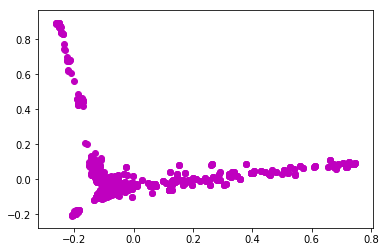

In [42]:
from sklearn.decomposition import PCA
%matplotlib inline

n=2
tf_idf_dense = tf_idf_m.todense()
coords = PCA(n_components=n).fit_transform(tf_idf_dense)

plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [54]:
n_clusters = 8
normalizer = Normalizer(copy=False)
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
spherical_kmeans = make_pipeline(normalizer, clf)
labels = clf.fit_predict(tf_idf_m)

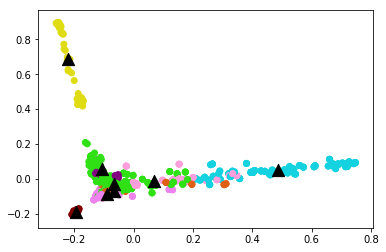

In [55]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0","#ee82ee","#ff9edd","#800000","#800080"]
color = [label[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = PCA(n_components=n).fit(tf_idf_dense).transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()

## Procesamiento Similaridad

In [56]:
sims = gensim.similarities.Similarity('./',tf_idf[corpus],
                                      num_features=len(dictionary))
print(sims)
print(type(sims))

/home/kref/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:718: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Similarity index with 1500 documents in 0 shards (stored under ./)
<class 'gensim.similarities.docsim.Similarity'>


### Query

In [ ]:
def make_query_tf_idf(query):
    query_doc = [w.lower() for w in word_tokenize(query)]
    query_doc_bow = dictionary.doc2bow(query_doc)
    return tf_idf[query_doc_bow]

In [111]:
def get_n_most_similar(mail_id, n):
  query = data['body_lemma'][mail_id]
  print('------------------------ [ Query ] ------------------------')
  print(data['body'][mail_id])
  ranking = sims[make_query_tf_idf(query)]
  sim_w_index = list(enumerate(ranking))
  x = [t[0] for t in list(reversed(sorted(sim_w_index,key=lambda x: x[1])))][1:]
  print()
  print('---------- [ Most similar emails (index, score)] ----------')
  print(list(reversed(sorted(sim_w_index,key=lambda x: x[1])))[1:n])
  print()
  print('------------------------ [ emails] ------------------------')
  for ind in x[:n]:
    print('Mail: {}'.format(ind))
    print('From: {}'.format(data['From'][ind]))
    print('To: {}'.format(data['To'][ind]))
    print(data['body'][ind])
    print('---------------------------------------------------------')
  return x[:n]

In [112]:
data['body_lemma'][70]

'office new year begin informal fundies meeting day cover happened market since filed bankruptcy go pipeline flow storage balance weather monthly daily price etc bank showing interest showing bid thought good u begin preparation trade market chris gaskill providing daily packet patti sullivan provide daily operation report thinking start around morning grigsby'

In [116]:
sim_indexes = get_n_most_similar(437,5)

------------------------ [ Query ] ------------------------
Mike,

Give me a call. 403-974-6910

Chris

---------- [ Most similar emails (index, score)] ----------
[(435, 0.31143972), (431, 0.28501302), (440, 0.19152886), (1123, 0.1784796)]

------------------------ [ emails] ------------------------
Mail: 435
From: {'chris.dorland@enron.com'}
To: {'keith.holst@enron.com'}
Keith,

How was Portland? I'm out of the office moving most of Monday but I'll give you a call on Tuesday. Did you get a chance to drop of my keys at the rental office?

Chris
---------------------------------------------------------
Mail: 431
From: {'chris.dorland@enron.com'}
To: {'keith.holst@enron.com'}
Apparently I have the wrong number. Give me a call when you get out of the meeting.

Chris

 -----Original Message-----
From: 	Holst, Keith  
Sent:	Wednesday, October 17, 2001 2:16 PM
To:	Dorland, Chris
Subject:	FW: Fundies Call

 << File: mtg.xls >> 

 -----Original Message-----
From: 	Rangel, Ina  
Sent:	Wednesda

### Analisis Grafico

In [117]:
sim_coords = np.asarray([ coords[x] for x in sim_indexes ])

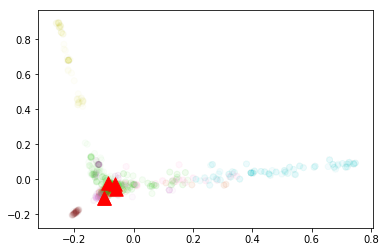

In [118]:
plt.scatter(coords[:, 0], coords[:, 1], c=color, alpha=0.025)
plt.scatter(sim_coords[:, 0], sim_coords[:, 1],marker='^', c='red',s=180)
plt.show()